# Toy Problem

## Imports

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch

Setup

In [2]:
x_plot = torch.linspace(0, 1, 200).reshape(-1, 1)

# enable LaTeX rendering
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    }
)

## Generate Toy Problem Data

In [3]:
def hf_fun(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)


def lf_fun(x):
    return 0.5 * hf_fun(x) + 10 * (x - 0.5) - 5


n_lfd = 21
x_lfd = np.linspace(0, 1, n_lfd)
F_lfd = lf_fun(x_lfd)

n_hfd = 9
x_hfd = np.linspace(0.4, 0.8, n_hfd)
F_hfd = hf_fun(x_hfd)

hfd_nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
    x_hfd.reshape(-1, 1)
)
lfd_distance, _ = hfd_nbrs.kneighbors(x_lfd.reshape(-1, 1))
hfd_distance, _ = hfd_nbrs.kneighbors(x_hfd.reshape(-1, 1))

lfd = {
    "x": x_lfd,
    "F": F_lfd,
    "lfhf": np.zeros_like(x_lfd),
    "distance": lfd_distance.squeeze(),
}
hfd = {
    "x": x_hfd,
    "F": F_hfd,
    "lfhf": np.ones_like(x_hfd),
    "distance": hfd_distance.squeeze(),
}
df_lf = pd.DataFrame(lfd)
df_hf = pd.DataFrame(hfd)
df = pd.concat([df_lf, df_hf])

df.head()

,x,F,lfhf,distance
0,0.00,-8.486395,0.0,0.40
1,0.05,-9.130743,0.0,0.35
2,0.10,-9.328288,0.0,0.30
3,0.15,-8.989140,0.0,0.25
4,0.20,-8.319864,0.0,0.20


Plot utility function

In [4]:
def plot_prediction(x_plot, pred, label="Prediction"):
    plt.plot(x_plot, pred, label=label, c="black", linewidth=2)
    plt.scatter(df_lf["x"], df_lf["F"], s=20, c="blue", label="$\mathcal{D}^\mathrm{LF}$")
    plt.scatter(df_hf["x"], df_hf["F"], s=20, c="red", label="$\mathcal{D}^\mathrm{HF}$")
    plt.yticks([-10, 0, 10])
    plt.xticks([0, 0.5, 1])
    plt.xlabel(r"$x$")
    plt.legend()
    plt.show()

## Plot training data

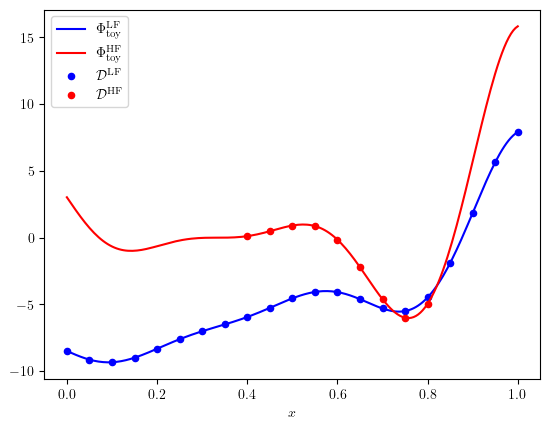

In [5]:
plt.plot(
    x_plot.detach().numpy(),
    lf_fun(x_plot.detach().numpy()),
    c="blue",
    label="$\Phi_{\mathrm{toy}}^\mathrm{LF}$",
)
plt.plot(
    x_plot.detach().numpy(),
    hf_fun(x_plot.detach().numpy()),
    c="red",
    label="$\Phi_{\mathrm{toy}}^\mathrm{HF}$",
)
plt.scatter(df_lf["x"], df_lf["F"], s=20, c="blue", label="$\mathcal{D}^\mathrm{LF}$")
plt.scatter(df_hf["x"], df_hf["F"], s=20, c="red", label="$\mathcal{D}^\mathrm{HF}$")

plt.xlabel("$x$")
plt.legend()
plt.show()

## Train Baseline

In [6]:
baseline_model = torch.nn.Sequential(
    torch.nn.Linear(1, 500),
    torch.nn.Softplus(),
    torch.nn.Linear(500, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 1),
)
best_baseline_model = None
best_loss = float("inf")
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001, weight_decay=1e-10)
x = torch.tensor(df[["x"]].values, dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(df["F"].values, dtype=torch.float32).reshape(-1, 1)
for i in range(10000):
    optimizer.zero_grad()
    y_pred = baseline_model(x)
    loss = torch.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_baseline_model = deepcopy(baseline_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_loss}")

Epoch 1000, loss: 2.4931633472442627, best loss: 2.4931633472442627
Epoch 2000, loss: 2.471965789794922, best loss: 2.45619535446167
Epoch 3000, loss: 2.443222999572754, best loss: 2.443222999572754
Epoch 4000, loss: 2.436386823654175, best loss: 2.436386823654175
Epoch 5000, loss: 2.437201976776123, best loss: 2.4338390827178955
Epoch 6000, loss: 2.432616710662842, best loss: 2.432616710662842
Epoch 7000, loss: 2.4320154190063477, best loss: 2.4320015907287598
Epoch 8000, loss: 2.4316186904907227, best loss: 2.4316186904907227
Epoch 9000, loss: 2.4314684867858887, best loss: 2.431443452835083
Epoch 10000, loss: 2.4313437938690186, best loss: 2.4313437938690186


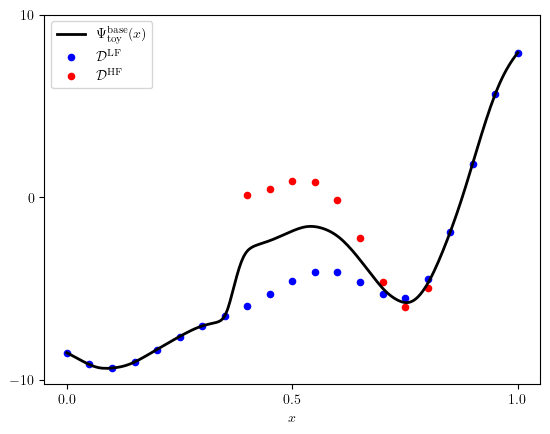

In [7]:
y_pred = best_baseline_model(x_plot).detach().numpy()
plot_prediction(x_plot, y_pred, '$\Psi^{\mathrm{base}}_{\mathrm{toy}}(x)$')

## Train Filter

In [8]:
filered_df = df[(df["distance"] > 0) | (df["lfhf"] == 1)]

filter_model = torch.nn.Sequential(
    torch.nn.Linear(1, 500),
    torch.nn.Softplus(),
    torch.nn.Linear(500, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 1),
)
best_filter_model = None
best_loss = float("inf")
optimizer = torch.optim.Adam(filter_model.parameters(), lr=0.001, weight_decay=1e-10)
x = torch.tensor(filered_df["x"].values.reshape(-1, 1), dtype=torch.float32)
y = torch.tensor(filered_df["F"].values.reshape(-1, 1), dtype=torch.float32)
for i in range(10000):
    optimizer.zero_grad()
    y_pred = filter_model(x)
    loss = torch.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_filter_model = deepcopy(filter_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_loss}")

Epoch 1000, loss: 0.24046318233013153, best loss: 0.24046318233013153
Epoch 2000, loss: 0.035076577216386795, best loss: 0.035076577216386795
Epoch 3000, loss: 0.011625556275248528, best loss: 0.011625556275248528
Epoch 4000, loss: 0.0072532957419753075, best loss: 0.0062699574045836926
Epoch 5000, loss: 0.003540804609656334, best loss: 0.003540804609656334
Epoch 6000, loss: 0.013698509894311428, best loss: 0.0018107036594301462
Epoch 7000, loss: 0.0008171085501089692, best loss: 0.0008171085501089692
Epoch 8000, loss: 0.00037195917684584856, best loss: 0.00027753389440476894
Epoch 9000, loss: 0.00010087060218211263, best loss: 0.00010087060218211263
Epoch 10000, loss: 6.632200529566035e-05, best loss: 4.9513477279106155e-05


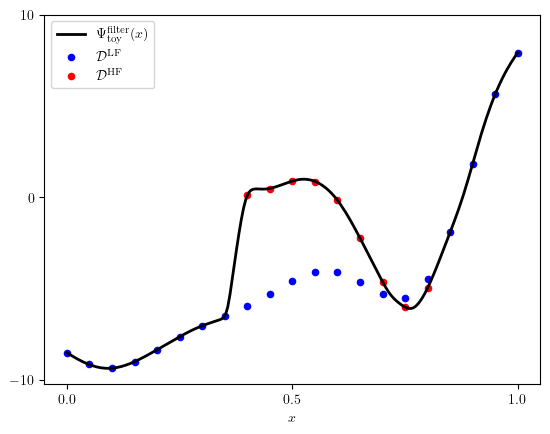

In [9]:
y_pred = best_filter_model(x_plot).detach().numpy()
plot_prediction(x_plot, y_pred, '$\Psi^{\mathrm{filter}}_{\mathrm{toy}}(x)$')

## Train Pretrain

In [10]:
pretrain_model = torch.nn.Sequential(
    torch.nn.Linear(1, 500),
    torch.nn.Softplus(),
    torch.nn.Linear(500, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 100),
    torch.nn.Softplus(),
    torch.nn.Linear(100, 1),
)
best_pretrain_model = None
best_loss = float("inf")
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.001, weight_decay=1e-10)
x_lf = torch.tensor(df[df["lfhf"] == 0]["x"].values.reshape(-1, 1), dtype=torch.float32)
y_lf = torch.tensor(df[df["lfhf"] == 0]["F"].values.reshape(-1, 1), dtype=torch.float32)
x_hf = torch.tensor(df[df["lfhf"] == 1]["x"].values.reshape(-1, 1), dtype=torch.float32)
y_hf = torch.tensor(df[df["lfhf"] == 1]["F"].values.reshape(-1, 1), dtype=torch.float32)
for i in range(5000):
    optimizer.zero_grad()
    y_pred = pretrain_model(x_lf)
    loss = torch.nn.functional.mse_loss(y_pred, y_lf)
    loss.backward()
    optimizer.step()
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_pretrain_model = deepcopy(pretrain_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_loss}")
print("Second stage:")
pretrain_model.load_state_dict(best_pretrain_model.state_dict())
best_val_loss = float("inf")
for i in range(5000):
    optimizer.zero_grad()
    y_pred = pretrain_model(x_hf)
    loss = torch.nn.functional.mse_loss(y_pred, y_hf)
    loss.backward()
    optimizer.step()
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        best_pretrain_model = deepcopy(pretrain_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_val_loss}")

Epoch 1000, loss: 0.09828861802816391, best loss: 0.09828861802816391
Epoch 2000, loss: 0.003921504598110914, best loss: 0.003921504598110914
Epoch 3000, loss: 0.004949972964823246, best loss: 0.0031945998780429363
Epoch 4000, loss: 0.0028187306597828865, best loss: 0.0027927763294428587
Epoch 5000, loss: 0.002500163624063134, best loss: 0.002500163624063134
Second stage:
Epoch 1000, loss: 0.0021633687429130077, best loss: 0.0021633687429130077
Epoch 2000, loss: 0.001701799570582807, best loss: 0.001701799570582807
Epoch 3000, loss: 0.0013299307320266962, best loss: 0.0013299307320266962
Epoch 4000, loss: 0.008941694162786007, best loss: 0.0008551811333745718
Epoch 5000, loss: 0.0005158929852768779, best loss: 0.0004187590384390205


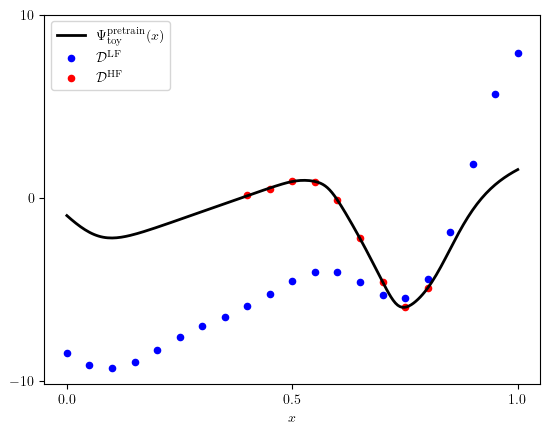

In [11]:
y_pred = best_pretrain_model(x_plot).detach().numpy()
plot_prediction(x_plot, y_pred, '$\Psi^{\mathrm{pretrain}}_{\mathrm{toy}}(x)$')

## Train Decidernet

In [12]:
decider_model = torch.nn.Sequential(
    torch.nn.Linear(1, 500),
    torch.nn.Softplus(),
    torch.nn.Linear(500, 200),
    torch.nn.Softplus(),
    torch.nn.Linear(200, 1),
    torch.nn.Sigmoid(),
)
predictor_model = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.Softplus(),
    torch.nn.Linear(500, 200),
    torch.nn.Softplus(),
    torch.nn.Linear(200, 200),
    torch.nn.Softplus(),
    torch.nn.Linear(200, 1),
)

best_decider_model = None
best_decider_loss = float("inf")
decider_optimizer = torch.optim.Adam(
    decider_model.parameters(), lr=0.001, weight_decay=1e-10
)
best_predictor_model = None
best_predictor_loss = float("inf")
predictor_optimizer = torch.optim.Adam(
    predictor_model.parameters(), lr=0.001, weight_decay=1e-10
)

x = torch.tensor(df["x"].values.reshape(-1, 1), dtype=torch.float32)
y_class = torch.tensor(df["lfhf"].values.reshape(-1, 1), dtype=torch.float32)
x_pred = torch.tensor(df[["x", "lfhf"]].values, dtype=torch.float32)
y = torch.tensor(df["F"].values.reshape(-1, 1), dtype=torch.float32)
for i in range(10000):
    decider_optimizer.zero_grad()
    y_pred = decider_model(x)
    loss = torch.nn.functional.mse_loss(y_pred, y_class)
    loss.backward()
    decider_optimizer.step()
    if loss.item() < best_decider_loss:
        best_decider_loss = loss.item()
        best_decider_model = deepcopy(decider_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_decider_loss}")

for i in range(10000):
    predictor_optimizer.zero_grad()
    y_pred = predictor_model(x_pred)
    loss = torch.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    predictor_optimizer.step()
    if loss.item() < best_predictor_loss:
        best_predictor_loss = loss.item()
        best_predictor_model = deepcopy(predictor_model)
    if (i + 1) % 1000 == 0:
        print(f"Epoch {i+1}, loss: {loss}, best loss: {best_predictor_loss}")

Epoch 1000, loss: 0.1556217223405838, best loss: 0.15561790764331818
Epoch 2000, loss: 0.15337128937244415, best loss: 0.1528267115354538
Epoch 3000, loss: 0.15175393223762512, best loss: 0.1517440378665924
Epoch 4000, loss: 0.1528053730726242, best loss: 0.15130585432052612
Epoch 5000, loss: 0.15174435079097748, best loss: 0.15103769302368164
Epoch 6000, loss: 0.1513199657201767, best loss: 0.15084266662597656
Epoch 7000, loss: 0.1506938338279724, best loss: 0.1506938338279724
Epoch 8000, loss: 0.1516750007867813, best loss: 0.1505770981311798
Epoch 9000, loss: 0.15039680898189545, best loss: 0.1503811776638031
Epoch 10000, loss: 0.1501406729221344, best loss: 0.1501355618238449
Epoch 1000, loss: 0.2839840352535248, best loss: 0.2569432556629181
Epoch 2000, loss: 0.04871601238846779, best loss: 0.04871601238846779
Epoch 3000, loss: 0.004991643596440554, best loss: 0.004991643596440554
Epoch 4000, loss: 0.0013939846539869905, best loss: 0.0013308360939845443
Epoch 5000, loss: 0.0004107

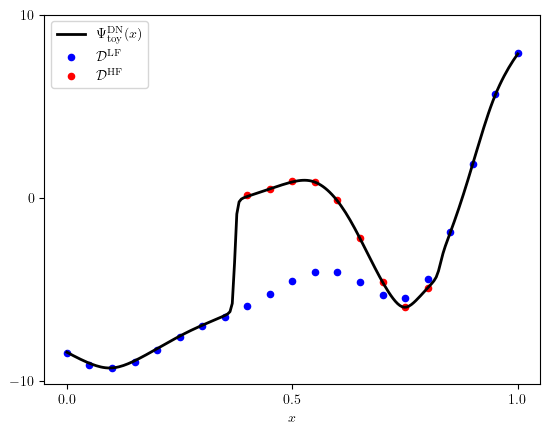

In [13]:
def sigmoid(x, steepness=20, threshold=0.5):
    return 1 / (1 + np.exp(-(x - threshold) * steepness))


y_fidelity = sigmoid(best_decider_model(x_plot).detach().numpy(), threshold=0.25)
x_fid = torch.tensor(np.concatenate((x_plot, y_fidelity), axis=1), dtype=torch.float32)
y_hf = best_predictor_model(
    torch.tensor(
        np.concatenate((x_plot, np.ones(len(x_plot)).reshape(-1, 1)), axis=1),
        dtype=torch.float32,
    )
)
y_lf = best_predictor_model(
    torch.tensor(
        np.concatenate((x_plot, np.zeros(len(x_plot)).reshape(-1, 1)), axis=1),
        dtype=torch.float32,
    )
)
y_pred = y_fidelity * y_hf.detach().numpy() + (1 - y_fidelity) * y_lf.detach().numpy()
plot_prediction(x_plot, y_pred, '$\Psi^{\mathrm{DN}}_{\mathrm{toy}}(x)$')